# Carrier Recovery & PED/FEDs

## Frequency Error Detector (FED)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from rfproto import filter, impairments, measurements, multirate, nco, pi_filter, plot, sig_gen

In [ ]:
fs = 100.0e3
f_start = -fs/2
f_end = fs/2
num_samples = int(fs) # 1 second

lfm_chirp_sig = sig_gen.cmplx_dt_lfm_chirp(100, f_start, f_end, fs, num_samples)
mid_pt = int(len(lfm_chirp_sig)/2)
margin = 1000
plot.samples(np.real(lfm_chirp_sig[mid_pt - margin:mid_pt + margin]))
plt.show()

f, t, Zxx = signal.stft(np.real(lfm_chirp_sig), fs, nperseg=100)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=2, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
class Dfd:
    def __init__(self):
       self.z1 = 0 + 1j*0

    def Step(self, x):
        retval = (self.z1.imag * x.real) - (self.z1.real * x.imag)
        self.z1 = x
        return retval

In [ ]:
freq_disc = np.zeros(len(lfm_chirp_sig))
test_dfd = Dfd()

for i in range(len(lfm_chirp_sig)):
    freq_disc[i] = test_dfd.Step(lfm_chirp_sig[i])

plt.plot(freq_disc)
plt.show()

Blind, Non-Data Aided (NDA) FLL can be made by RRC/match filtering, Mth power to fold phase into sinusoid which has frequency offset at $M$ times the CFO, LPF'ing then using L&R type autocorrelation FED (see above) loop filtered to drive frequency error to zero.

In [ ]:
symbol_rate = 5e6
OSR = 4
output_fs = OSR * symbol_rate
rrc_alpha = 0.25
num_symbols = 4096
in_symbols = np.random.randint(0, 4, num_symbols).tolist()
output_iq = sig_gen.gen_mod_signal(
    "QPSK",
    in_symbols,
    output_fs,
    symbol_rate,
    "RRC",
    rrc_alpha,
)

output_iq = impairments.freq_offset_static(output_iq, 1e3, output_fs)

plot.IQ(output_iq, alpha=0.1)
plot.plt.show()

In [ ]:
plot.spec_an(output_iq, fs=output_fs, fft_shift=True, show_SFDR=False, y_unit="dB")
plt.show()

### M-th Power Detector

Raising an $M$-PSK signal to the $M$-th power is useful in coarse frequency/phase estimation as it wipes phase-modulation, revealing a tone at $M$ times the estimated frequency offset. 

For example in QPSK, symbols have phases separated by 90° (e.g., 45°, 135°, 225°, 315°), representing 2 bits per symbol. When you raise a complex QPSK symbol to the 4th power, its phase angle is multiplied by 4 (e.g., $4\times 45^{\circ }=180^{\circ }, 4\times 135^{\circ }=540^{\circ }\equiv 180^{\circ }$). Because $4\times 90^{\circ }=360^{\circ }$ (a full circle), all four QPSK symbols, regardless of their initial data-driven phase, end up at the same phase location (e.g., all map to $0^{\circ }$ or $180^{\circ }$). What remains after this operation is primarily the unmodulated carrier's phase drift (frequency offset) and noise, at $4\times$ the frequency offset (e.x. a 1kHz offset would show up as a 4kHz tone).

In [ ]:
iq_4th = output_iq ** 4.0

mth_spec = 20.0 * np.log10(np.abs(np.fft.fftshift(np.fft.fft(iq_4th))))
freqBin = np.linspace(-len(mth_spec) // 2, len(mth_spec) // 2, len(mth_spec)) * (output_fs / len(mth_spec))
plt.plot(freqBin, mth_spec, linewidth=0.5)
plt.show()
print(f"Frequency offset (est.): {freqBin[np.argmax(mth_spec)] / 4.0} Hz")

### References

* [MATLAB comm.CoarseFrequencyCompensator - Algorithms](https://www.mathworks.com/help/comm/ref/comm.coarsefrequencycompensator-system-object.html#buu65t5-1_sep_buu7878)

## Combined Carrier Recovery

When frequency offset is not significant (e.x. majority of signal bandwidth is still within passband of matched filter, and/or when Coarse Frequency Correction (CFC) has already been applied upstream), frequency and phase errors can be jointly compensated in a _carrier recovery_ scheme.



### Decision Directed Phase Detector

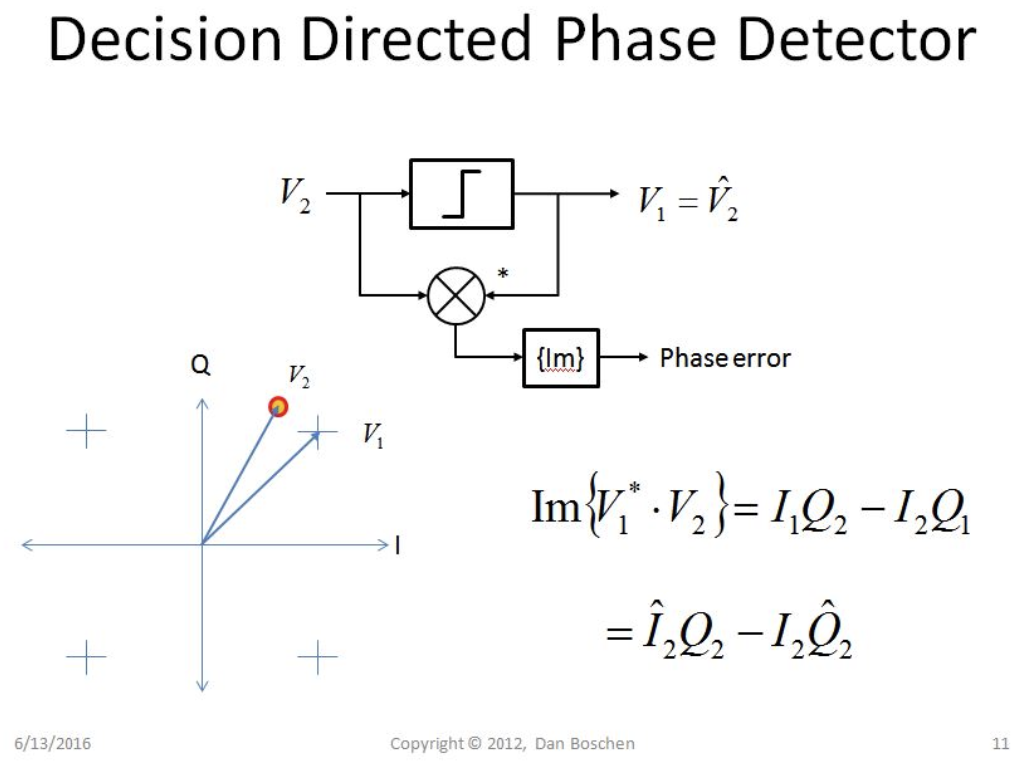

_From [How to correct the phase offset for QPSK I-Q data](https://dsp.stackexchange.com/a/31506)_

Any M-PSK/QAM modulation can derive a decision-directed phase error via:

$$ \text{PED} = \hat{I}Q - I\hat{Q} $$

**NOTE:** $ \hat{I} $ is the decision point for sample $I$. In QPSK, this is the deviation from the ideal constellation/sampling point (at normalized magnitudes this is $\pm 0.707 \pm j0.707$). In general, any M-PSK modulation can derive phase error from subtracting the reference phase/constellation from the input sample (containing phase error).

In [ ]:
def qpsk_costas(x, ref_mag):
    # Ideal QPSK I or Q constellation magnitude given input avg. reference magnitude of input samples
    ref_point = ref_mag / np.sqrt(2.0)
    i_decision = np.sign(np.real(x)) * (np.abs(np.real(x)) - ref_point)
    q_decision = np.sign(np.imag(x)) * (np.abs(np.imag(x)) - ref_point)
    return (i_decision * np.imag(x)) - (np.real(x) * q_decision)

In [ ]:
M = OSR // 2 # Decimation factor to get to 2x Samples/Symbol (SPS)
rx_rrc = filter.RootRaisedCosine(output_fs, symbol_rate, rrc_alpha, 25)
rx_shaped = signal.lfilter(rx_rrc, 1, output_iq)

downsampled = multirate.decimate(rx_shaped, M)[::2]

plot.IQ(downsampled, alpha=0.1)
plt.show()

In [ ]:
cr_nco = nco.Nco(32, 16, 10, output_fs/OSR)
cr_filt = pi_filter.PiFilter(0.001, 1e-1)

N_out = len(downsampled)
nco_out = np.zeros(N_out) + 1j*np.zeros(N_out)
ped_out = np.zeros(N_out)
pi_filt_out = np.zeros(N_out)
for i in range(N_out):
    nco_out[i] = downsampled[i] * cr_nco.GetCurrentNcoOutput()
    # NOTE: magic number of reference magnitude known a priori from magnitude average calc at bottom of page
    ped_out[i] = qpsk_costas(nco_out[i], 11396)
    pi_filt_out[i] = cr_filt.Step(ped_out[i])
    cr_nco.IncPhaseAcc(pi_filt_out[i])

plt.plot(ped_out, '.', alpha=0.1)
plt.title("QPSK Costas PED Output")
plt.show()

plt.plot(pi_filt_out, '.', alpha=0.1)
plt.title("PI Filter Output")
plt.show()

plt.plot(nco.FcwToFreq(pi_filt_out, 32, output_fs/OSR), '.', alpha=0.1)
plt.title("NCO Frequency")
plt.show()

plot.IQ(nco_out, alpha=0.1)
plt.title("I/Q Output")
plt.show()

In [ ]:
print(f"Output avg. mag: {np.mean(np.abs(nco_out))}")

## References

* [High modulation index PSK - carrier recovery - DSP Stack Exchange](https://dsp.stackexchange.com/questions/17297/high-modulation-index-psk-carrier-recovery)
  + [How does this FLL work? - DSP Stack Exchange](https://dsp.stackexchange.com/questions/42239/how-does-this-fll-work/52163#52163)
* [How to correct the phase offset for QPSK I-Q data - DSP Stack Exchange](https://dsp.stackexchange.com/a/31506)
* [Mathworks Carrier Synchronizer System Object](https://www.mathworks.com/help/comm/ref/comm.carriersynchronizer-system-object.html)